# II.3 QR factorisation

Let $A ∈ ℂ^{m × n}$ be a rectangular or square matrix such that $m ≥ n$ (i.e. more rows then columns).
In this chapter we consider two closely related factorisations:

1. The _QR factorisation_
$$
A = Q R = \underbrace{\begin{bmatrix} 𝐪_1 | ⋯ | 𝐪_m \end{bmatrix}}_{Q ∈ U(m)} \underbrace{\begin{bmatrix} × & ⋯ & × \\ & ⋱ & ⋮ \\ && × \\ &&0 \\ &&⋮ \\ && 0 \end{bmatrix}}_{R ∈ ℂ^{m × n}}
$$
where $Q$ is unitary (i.e., $Q ∈ U(m)$, satisfying $Q^⋆Q = I$, with columns $𝐪_j ∈ ℂ^m$) and $R$ is _right triangular_, which means it 
is only nonzero on or to the right of the diagonal ($r_{kj} = 0$ if $k > j$).

2. The _reduced QR factorisation_
$$
A = \hat Q \hat R = \underbrace{\begin{bmatrix} 𝐪_1 | ⋯ | 𝐪_n \end{bmatrix}}_{ \hat Q ∈ ℂ^{m × n}} \underbrace{\begin{bmatrix} × & ⋯ & × \\ & ⋱ & ⋮ \\ && ×  \end{bmatrix}}_{\hat R ∈ ℂ^{n × n}}
$$
where $Q$ has orthogonal columns ($Q^⋆ Q = I$, $𝐪_j ∈ ℂ^m$) and $\hat R$ is upper triangular.

Note for a square matrix the reduced QR factorisation is equivalent to the QR factorisation, in which case $R$ is _upper triangular_.
The importance of these decomposition for square matrices is that their component pieces are easy to invert:
$$
A = QR \qquad ⇒ \qquad A^{-1}𝐛 = R^{-1} Q^⊤ 𝐛
$$
and we saw in the last two chapters that triangular and orthogonal matrices are easy to invert when applied to a vector $𝐛$,
e.g., using forward/back-substitution.

For rectangular matrices we will see that they lead to efficient solutions to the _least squares problem_: find
$𝐱$ that minimizes the 2-norm
$$
\| A 𝐱 - 𝐛 \|.
$$
Note in the rectangular case the QR decomposition contains within it the reduced QR decomposition:
$$
A = QR = \begin{bmatrix} \hat Q | 𝐪_{n+1} | ⋯ | 𝐪_m \end{bmatrix} \begin{bmatrix} \hat R \\  𝟎_{m-n × n} \end{bmatrix} = \hat Q \hat R.
$$




In this lecture we discuss the followng:

1. QR and least squares: We discuss the QR decomposition and its usage in solving least squares problems.
2. Reduced QR and Gram–Schmidt: We discuss computation of the Reduced QR decomposition using Gram–Schmidt.
3. Householder reflections and QR: We discuss computing the  QR decomposition using Householder reflections.

In [1]:
using LinearAlgebra, Plots, BenchmarkTools

## 1. QR and least squares

Here we consider rectangular matrices with more rows than columns. Given $A ∈ ℂ^{m × n}$ and $𝐛 ∈ ℂ^m$,
least squares consists of finding a vector $𝐱 ∈ ℂ^n$ that minimises the 2-norm:
$
\| A 𝐱 - 𝐛 \|
$.


**Theorem 1 (least squares via QR)** Suppose $A ∈ ℂ^{m × n}$ has full rank. Given a QR decomposition $A = Q R$
then
$$
𝐱 = \hat R^{-1} \hat Q^⋆ 𝐛
$$
minimises $\| A 𝐱 - 𝐛 \|$. 

**Proof**

The norm-preserving property (see PS4 Q3.1) of unitary matrices tells us
$$
\| A 𝐱 - 𝐛 \| = \| Q R 𝐱 - 𝐛 \| = \| Q (R 𝐱 - Q^⋆ 𝐛) \| = \| R 𝐱 - Q^⋆ 𝐛 \| = \left \| 
\begin{bmatrix} \hat R \\ 𝟎_{m-n × n} \end{bmatrix} 𝐱 - \begin{bmatrix} \hat Q^⋆ \\ 𝐪_{n+1}^⋆ \\ ⋮ \\ 𝐪_m^⋆ \end{bmatrix}     𝐛 \right \|
$$
Now note that the rows $k > n$ are independent of $𝐱$ and are a fixed contribution. Thus to minimise this norm it suffices to
drop them and minimise:
$$
\| \hat R 𝐱 - \hat Q^⋆ 𝐛 \|
$$
This norm is minimised if it is zero. Provided the column rank of $A$ is full, $\hat R$ will be invertible (Exercise: why is this?).

∎


**Example 1 (quadratic fit)** Suppose we want to fit noisy data by a quadratic
$$
p(x) = p₀ + p₁ x + p₂ x^2
$$
That is, we want to choose $p₀,p₁,p₂$ at data samples $x_1, …, x_m$ so that the following is true:
$$
p₀ + p₁ x_k + p₂ x_k^2 ≈ f_k
$$
where $f_k$ are given by data. We can reinterpret this as a least squares problem: minimise the norm
$$
\left\| \begin{bmatrix} 1 & x_1 & x_1^2 \\ ⋮ & ⋮ & ⋮ \\ 1 & x_m & x_m^2 \end{bmatrix}
\begin{bmatrix} p₀ \\ p₁ \\ p₂ \end{bmatrix} - \begin{bmatrix} f_1 \\ ⋮ \\ f_m \end{bmatrix} \right \|
$$
We can solve this using the QR decomposition:

In [2]:
m,n = 100,3

x = range(0,1; length=m) # 100 points
f = 2 .+ x .+ 2x.^2 .+ 0.1 .* randn.() # Noisy quadratic

A = x .^ (0:2)'  # 100 x 3 matrix, equivalent to [ones(m) x x.^2]
Q,R̂ = qr(A)
Q̂ = Q[:,1:n] # Q represents full orthogonal matrix so we take first 3 columns

p₀,p₁,p₂ = R̂ \ Q̂'f

3-element Vector{Float64}:
 2.0172265583556173
 0.857813720251557
 2.1358409286607394

We can visualise the fit:

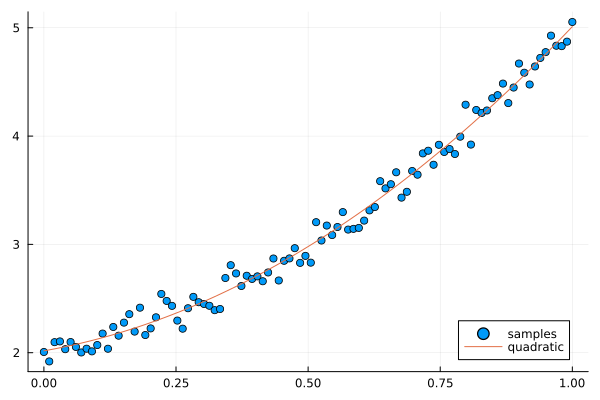

In [3]:
p = x -> p₀ + p₁*x + p₂*x^2

scatter(x, f; label="samples", legend=:bottomright)
plot!(x, p.(x); label="quadratic")

Note that `\` with a rectangular system does least squares by default:

In [4]:
A \ f

3-element Vector{Float64}:
 2.0172265583556177
 0.8578137202515559
 2.13584092866074

## 2. Reduced QR and Gram–Schmidt


How do we compute the QR decomposition? We begin with a method
you may have seen before in another guise. Write
$$
A = \begin{bmatrix} 𝐚_1 | ⋯ | 𝐚_n \end{bmatrix}
$$
where $𝐚_k ∈  ℂ^m$ and assume they are linearly independent ($A$ has full column rank).


**Proposition 1 (Column spaces match)** Suppose $A = \hat Q  \hat R$ where $\hat Q = [𝐪_1|…|𝐪_n]$
has orthogonal columns and $\hat R$ is upper-triangular, and $A$ has full rank.
Then the first $j$ columns of
$\hat Q$ span the same space as the first $j$ columns of $A$:
$$
\hbox{span}(𝐚_1,…,𝐚_j) = \hbox{span}(𝐪_1,…,𝐪_j).
$$

**Proof**

Because $A$ has full rank we know $\hat R$ is invertible, i.e. its diagonal entries do not vanish: $r_{jj} ≠ 0$.
If $𝐯 ∈ \hbox{span}(𝐚_1,…,𝐚_j)$ we have for $𝐜 ∈ ℂ^j$
$$
𝐯 = \begin{bmatrix} 𝐚_1 | ⋯ | 𝐚_j \end{bmatrix} 𝐜 = 
\begin{bmatrix} 𝐪_1 | ⋯ | 𝐪_j \end{bmatrix}  \hat R[1:j,1:j] 𝐜 ∈ \hbox{span}(𝐪_1,…,𝐪_j)
$$
 while if $𝐰 ∈ \hbox{span}(𝐪_1,…,𝐪_j)$ we have for $𝐝 ∈ ℝ^j$
$$
𝐰 = \begin{bmatrix} 𝐪_1 | ⋯ | 𝐪_j \end{bmatrix} 𝐝  =  \begin{bmatrix} 𝐚_1 | ⋯ | 𝐚_j \end{bmatrix} \hat R[1:j,1:j]^{-1} 𝐝 ∈  \hbox{span}(𝐚_1,…,𝐚_j).
$$

∎

 
It is possible to find $\hat Q$ and $\hat R$ the  using the _Gram–Schmidt algorithm_.
We construct it column-by-column:

**Algorithm 1 (Gram–Schmidt)** For $j = 1, 2, …, n$ define
$$
\begin{align*}
𝐯_j &:= 𝐚_j - ∑_{k=1}^{j-1} \underbrace{𝐪_k^⋆ 𝐚_j}_{r_{kj}} 𝐪_k \\
r_{jj} &:= {\|𝐯_j\|} \\
𝐪_j &:= {𝐯_j \over r_{jj}}
\end{align*}
$$

**Theorem 2 (Gram–Schmidt and reduced QR)** Define $𝐪_j$ and $r_{kj}$ as in Algorithm 1
(with $r_{kj} = 0$ if $k > j$). Then a reduced QR decomposition is given by:
$$
A = \underbrace{\begin{bmatrix} 𝐪_1 | ⋯ | 𝐪_n \end{bmatrix}}_{ \hat Q ∈ ℂ^{m × n}} \underbrace{\begin{bmatrix} r_{11} & ⋯ & r_{1n} \\ & ⋱ & ⋮ \\ && r_{nn}  \end{bmatrix}}_{\hat R ∈ ℂ^{n × n}}
$$

**Proof**

We first show that $\hat Q$ has orthogonal columns. Assume that $𝐪_ℓ^⋆ 𝐪_k = δ_{ℓk}$ for $k,ℓ < j$. 
For $ℓ < j$ we then have
$$
𝐪_ℓ^⋆ 𝐯_j = 𝐪_ℓ^⋆ 𝐚_j - ∑_{k=1}^{j-1}  𝐪_ℓ^⋆𝐪_k 𝐪_k^⋆ 𝐚_j = 0
$$
hence $𝐪_ℓ^⋆ 𝐪_j = 0$ and indeed $\hat Q$ has orthogonal columns. Further: from the definition of $𝐯_j$ we find
$$
𝐚_j = 𝐯_j + ∑_{k=1}^{j-1} r_{kj} 𝐪_k = ∑_{k=1}^j r_{kj} 𝐪_k  = \hat Q \hat R 𝐞_j
$$

∎

### Gram–Schmidt in action

We are going to compute the reduced QR of a random matrix

In [5]:
m,n = 5,4
A = randn(m,n)
Q,R̂ = qr(A)
Q̂ = Q[:,1:n]

5×4 Matrix{Float64}:
 -0.70943    -0.454043   0.41333    0.344949
 -0.0439827  -0.275512  -0.320392  -0.138942
 -0.360728    0.548527  -0.493729   0.56686
 -0.419119    0.592301   0.369346  -0.541286
 -0.434729   -0.257365  -0.588492  -0.497378

The first column of `\hat Q` is indeed a normalised first column of `A`:

In [6]:
R = zeros(n,n)
Q = zeros(m,n)
R[1,1] = norm(A[:,1])
Q[:,1] = A[:,1]/R[1,1]

5-element Vector{Float64}:
 0.7094298199902744
 0.043982737231058715
 0.36072796028194515
 0.4191187281458683
 0.4347294327768107

We now determine the next entries as

In [7]:
R[1,2] = Q[:,1]'A[:,2]
v = A[:,2] - Q[:,1]*R[1,2]
R[2,2] = norm(v)
Q[:,2] = v/R[2,2]

5-element Vector{Float64}:
 -0.4540426563561427
 -0.27551156613455136
  0.5485266393297886
  0.5923009397834829
 -0.2573650438818667

And the third column is then:

In [8]:
R[1,3] = Q[:,1]'A[:,3]
R[2,3] = Q[:,2]'A[:,3]
v = A[:,3] - Q[:,1:2]*R[1:2,3]
R[3,3] = norm(v)
Q[:,3] = v/R[3,3]

5-element Vector{Float64}:
 -0.41332990163830907
  0.3203921940446482
  0.49372888242968505
 -0.3693457774967121
  0.5884919045382065

(Note the signs may not necessarily match.)

We can clean this up as a simple algorithm:

In [9]:
function gramschmidt(A)
    m,n = size(A)
    m ≥ n || error("Not supported")
    R = zeros(n,n)
    Q = zeros(m,n)
    for j = 1:n
        for k = 1:j-1
            R[k,j] = Q[:,k]'*A[:,j]
        end
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    Q,R
end

Q,R = gramschmidt(A)
norm(A - Q*R)

7.850462293418876e-17

### Complexity and stability

We see within the `for j = 1:n` loop that we have $O(mj)$ operations. Thus the 
total complexity is $O(m n^2)$ operations.


Unfortunately, the Gram–Schmidt algorithm is _unstable_: the rounding errors when implemented in floating point
accumulate in a way that we lose orthogonality:

In [10]:
A = randn(300,300)
Q,R = gramschmidt(A)
norm(Q'Q-I)

1.6958205615505476e-12

## 3. Householder reflections and QR

As an alternative, we will consider using Householder reflections to introduce zeros below
the diagonal.
Thus, if Gram–Schmidt is a process of _triangular orthogonalisation_ (using triangular matrices
to orthogonalise), Householder reflections is a process of _orthogonal triangularisation_ 
(using orthogonal matrices to triangularise).

Consider multiplication by the Householder reflection corresponding to the first column,
that is, for
$$
Q_1 := Q_{𝐚_1}^{\rm H},
$$
consider
$$
Q_1 A = \begin{bmatrix} × & × & ⋯ & × \\
& × & ⋯ & × \\
                    & ⋮ & ⋱ & ⋮ \\
                    & × & ⋯ & × \end{bmatrix} = 
\begin{bmatrix}  α & 𝐰^⊤ \\ 
& A_2   \end{bmatrix}
$$
where 
$$
α := -{\rm csign}(a_{11})  \|𝐚_1\|, 𝐰 = (Q_1 A)[1, 2:n]  \qquad \hbox{and} \qquad A_2 = (Q_1 A)[2:m, 2:n],
$$
${\rm csign}(z) :=  {\rm e}^{{\rm i} \arg z}$. 
That is, we have made the first column triangular.
In terms of an algorithm, we then introduce zeros into the first column of $A_2$,
leaving an $A_3$, and so-on. But we can wrap this iterative algorithm into a simple
proof by induction:

**Theorem 3 (QR)** 
Every matrix $A ∈ ℂ^{m × n}$ has a QR factorisation:
$$
A = QR
$$
where $Q ∈ U(m)$ and $R ∈ ℂ^{m × n}$ is right triangular.

**Proof**

Assume $m ≥ n$. If $A = [𝐚_1] ∈ ℂ^{m × 1}$ then we have for the Householder
reflection $Q_1 = Q_{𝐚_1}^{\rm H}$
$$
Q_1 A = [α 𝐞₁]
$$
which is right triangular, where $α = -{\rm sign}(a_{11}) \|𝐚_1\|$. 
In other words 
$$
A = \underbrace{Q_1}_Q \underbrace{[α 𝐞₁]}_R.
$$

For $n > 1$, assume every matrix with less columns than $n$ has a QR factorisation.
For $A = [𝐚_1|…|𝐚_n] ∈ ℂ^{m × n}$, let $Q_1 = Q_{𝐚_1}^{\rm H}$ so that
$$
Q_1 A =  \begin{bmatrix} α & 𝐰^⊤ \\ & A_2 \end{bmatrix}
$$
where $A_2 = (Q_1 A)[2:m,2:n]$ and $𝐰 = (Q_1 A)[1,2:n]$. By assumption $A_2 = \tilde Q \tilde R$. Thus we have
$$
\begin{align*}
A = Q_1 \begin{bmatrix} α & 𝐰^⊤ \\ & \tilde Q \tilde R \end{bmatrix} \\
=\underbrace{Q_1 \begin{bmatrix} 1 \\ & \tilde Q \end{bmatrix}}_Q  \underbrace{\begin{bmatrix} α & 𝐰^⊤ \\ &  \tilde R \end{bmatrix}}_R.
\end{align*}
$$

∎

This proof by induction leads naturally to an iterative algorithm. Note that $\tilde Q$ is a product of all
Householder reflections that come afterwards, that is, we can think of $Q$ as:
$$
Q = Q_1 \tilde Q_2 \tilde Q_3 ⋯ \tilde Q_n\qquad\hbox{for}\qquad \tilde Q_j = \begin{bmatrix} I_{j-1} \\ & Q_j \end{bmatrix}
$$
where $Q_j$ is a single Householder reflection corresponding to the first column of $A_j$. 
This is stated cleanly in Julia code:

**Algorithm 2 (QR via Householder)** For $A ∈ ℂ^{m × n}$ with $m ≥ n$, the QR factorisation can be implemented as follows:

In [11]:
function householderreflection(x)
    y = copy(x)
    if x[1] == 0
        y[1] += norm(x) 
    else # note sign(z) = exp(im*angle(z)) where `angle` is the argument of a complex number
        y[1] += sign(x[1])*norm(x) 
    end
    w = y/norm(y)
    I - 2*w*w'
end
function householderqr(A)
    T = eltype(A)
    m,n = size(A)
    if n > m
        error("More columns than rows is not supported")
    end

    R = zeros(T, m, n)
    Q = Matrix(one(T)*I, m, m)
    Aⱼ = copy(A)

    for j = 1:n
        𝐚₁ = Aⱼ[:,1] # first columns of Aⱼ
        Q₁ = householderreflection(𝐚₁)
        Q₁Aⱼ = Q₁*Aⱼ
        α,𝐰 = Q₁Aⱼ[1,1],Q₁Aⱼ[1,2:end]
        Aⱼ₊₁ = Q₁Aⱼ[2:end,2:end]

        # populate returned data
        R[j,j] = α
        R[j,j+1:end] = 𝐰

        # following is equivalent to Q = Q*[I 0 ; 0 Qⱼ]
        Q[:,j:end] = Q[:,j:end]*Q₁

        Aⱼ = Aⱼ₊₁ # this is the "induction"
    end
    Q,R
end

m,n = 100,50
A = randn(m,n)
Q,R = householderqr(A)
@test Q'Q ≈ I
@test Q*R ≈ A

Test Passed

Note because we are forming a full matrix representation of each Householder
reflection this is a slow algorithm, taking $O(n^4)$ operations. The problem sheet
will consider a better implementation that takes $O(n^3)$ operations.


**Example 2** We will now do an example by hand. Consider the $4 × 3$ matrix
$$
A = \begin{bmatrix} 
4 & 2 & -1 \\ 
0 & 15 & 18 \\
-2 & -4 & -4 \\
-2 & -4 & -10
\end{bmatrix}
$$
For the first column we have
$$
Q_1 = I - {1 \over 12} \begin{bmatrix} 4 \\ 0 \\ -2 \\ -2 \end{bmatrix} \begin{bmatrix} 4 & 0 & -2 & -2 \end{bmatrix} =
{1 \over 3} \begin{bmatrix}
-1 & 0 & 2 & 2 \\
0 & 3 & 0 & 0 \\
2 & 0 & 2 & -1 \\
2 & 0 & -1 &2
\end{bmatrix}
$$
so that
$$
Q_1 A = \begin{bmatrix} -3 & -6 & -9 \\
 & 15 & 18 \\
  & 0 & 0 \\
& 0 & -6
\end{bmatrix}
$$
In this example the next column is already upper-triangular,
but because of our choice of reflection we will end up swapping the sign, that is
$$
\tilde Q_2 = \begin{bmatrix} 1 \\ & -1 \\ && 1 \\ &&& 1 \end{bmatrix}
$$
so that
$$
\tilde Q_2 Q_1 A = \begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  & 0 & 0 \\
& 0 & -6
\end{bmatrix}
$$
The final reflection is
$$
\tilde Q_3 = \begin{bmatrix} I_{2 × 2} \\ &  I - \begin{bmatrix} 1 \\ -1 \end{bmatrix} \begin{bmatrix} 1 & -1 \end{bmatrix} 
\end{bmatrix} = \begin{bmatrix} å1 \\ & 1 \\ & & 0 & 1 \\ & & 1 & 0 \end{bmatrix}
$$
giving us
$$
\tilde Q_3 \tilde Q_2 Q_1 A = \underbrace{\begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  &  & -6 \\
&  & 0
\end{bmatrix}}_R
$$
That is,
$$
A = Q_1 \tilde Q_2 \tilde Q_3 R = \underbrace{{1 \over 3} \begin{bmatrix}
-1 & 0 & 2 & 2 \\
0 & 3 & 0 & 0 \\
2 & 0 & -1 & 2 \\
2 & 0 & 2 &-1
\end{bmatrix}}_Q \underbrace{\begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  &  & -6 \\
&  & 0
\end{bmatrix}}_R = \underbrace{{1 \over 3} \begin{bmatrix}
-1 & 0 & 2  \\
0 & 3 & 0  \\
2 & 0 & -1  \\
2 & 0 & 2 
\end{bmatrix}}_\hat Q  \underbrace{\begin{bmatrix} -3 & -6 & -9 \\
 & -15 & -18 \\
  &  & -6 
\end{bmatrix}}_\hat R
$$